In [1]:
import autograd.numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def initialize_parameters_deep(layer_dims): 
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) \
        * np.sqrt(2.0 / layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [3]:
def sigmoid(Z):
    return 1/(1 + np.exp(-Z)), Z

def relu(Z):
    return np.maximum(0, Z), Z

def tanh(Z):
    return np.tanh(Z), Z

def cos(Z):
    return np.cos(Z), Z

def softmax(Z):
    shift = Z - np.maximum(Z)
    exps = np.exp(shift)
    return exps / np.sum(exps), Z

def softplus(Z):
    return np.log(np.exp(Z) + 1), Z

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation, dA_prev):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        dA = np.multiply(A, 1 - A) * np.dot(W, dA_prev)  
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        dA = np.greater_equal(Z, 0) * np.dot(W, dA_prev)
    
    elif activation == "none":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = Z, Z
        dA = np.dot(W, dA_prev)
    
    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
        dA = (np.ones_like(A) - A**2) * np.dot(W, dA_prev)
        
    elif activation == "cos":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = cos(Z)
        dA = - np.sin(Z) * np.dot(W, dA_prev)
    
    elif activation == "softplus":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softplus(Z)
        dA =  sigmoid(Z)[0] * np.dot(W, dA_prev)
        
    elif activation == "softmax":
        pass
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    assert (dA.shape == A.shape)
    cache = (linear_cache, activation_cache)

    return A, cache, dA

In [4]:
def L_model_forward(X, parameters, activation):
    caches = []
    A = X
    dA = np.ones_like(A)
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        dA_prev = dA
        A, cache, dA = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation, dA_prev)
        caches.append(cache)

    AL, cache, dAL = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "none", dA)
    caches.append(cache)
    
    assert(AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))
    assert(dAL.shape == AL.shape)        
    return AL, caches, dAL

In [5]:
def sigmoid_backward(dA, activation_cache):
    y = sigmoid(activation_cache)[0]
    return np.multiply(dA, np.multiply(y, 1 - y))

def relu_backward(dA, activation_cache):
    y = np.greater_equal(activation_cache, 0)
    return np.multiply(dA, y)

def none_backward(dA, activation_cache):
    return dA

def cos_backward(dA, activation_cache):
    return np.multiply(dA, -np.sin(activation_cache))

def tanh_backward(dA, activation_cache):
    return np.multiply(dA, np.ones_like(dA) - np.tanh(activation_cache)**2)

def softplus_backward(dA, activation_cache):
    return np.multiply(dA, sigmoid(activation_cache)[0])

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    elif activation == "none":
        dZ = none_backward(dA, activation_cache)
    
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        
    elif activation == "cos":
        dZ = cos_backward(dA, activation_cache)
    
    elif activation == "softplus":
        dZ = softplus_backward(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [6]:
def L_model_backward(AL, dAL, caches, activation):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "none")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [7]:
def initialize_adam(parameters) :   
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
       
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
       
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)
      
    return parameters, v, s

In [8]:
from autograd import grad

def solve_1():
    def analytic_solution(t):
        return np.array([1 + np.sin(2*t), np.cos(2*t), np.cos(2*t), 1 - np.sin(2*t)])
    
    def grad_analytic_solution(t):
        return np.array([2*np.cos(2*t), -2*np.sin(2*t), -2*np.sin(2*t),  -2*np.cos(2*t)])
    
    def dX_dt(T, X):
        return np.array([X[2] + X[1], X[3] - X[0], X[3] - X[0], -1 * (X[2] + X[1])])
    
    def predicted_soln(T, AL):
        return np.multiply(T, AL) + 1
    
    def grad_predicted_soln(T, AL, dAL):
        return AL + T*dAL
        
    def cost(AL, dAL, T):
        X = predicted_soln(T, AL)
        term1 = dX_dt(T, X)
        term2 = AL + T*dAL
        cost = np.sum((term1 - term2)**2, axis = 0, keepdims = True)
        assert(cost.shape == (1, batch_size))
        cost = np.squeeze(np.mean(cost))
        return cost
    
    def compute_cost(AL, dAL, T):
        return cost(AL, dAL, T), grad(cost)(AL, dAL, T)
    
    batch_size = 100
    
    def get_data():
        h = np.random.uniform(-0.5,0.5,batch_size)
        h.shape = (1, batch_size)
        return h
    
    return get_data, predicted_soln, grad_predicted_soln, compute_cost, analytic_solution, grad_analytic_solution

In [9]:
def solve_2():
    
    def dX_dt(T, X):
        h1 = np.exp(T)
        g1 = (1 + T**2)
        g2 = (1 + T) ** 2
        f1 = h1/g1
        f2 = h1/g2
        return np.array([X[2] + X[1] + f1, X[3] - X[0] - f2, -X[0] + X[3] + f2, -X[1] - X[2] - f1]).reshape(4, T.shape[1])
    
    def predicted_soln(T, AL):
        sol = np.multiply(T, AL) + np.array([1, 0, 0, 1]).reshape((4, 1))
        assert(sol.shape == AL.shape)
        return sol
    
    def grad_predicted_soln(T, AL, dAL):
        return AL + T*dAL
    
    def cost(AL, dAL, T):
        X = predicted_soln(T, AL)
        term1 = dX_dt(T, X)
        term2 = AL + T*dAL
        cost = np.sum((term1 - term2)**2, axis = 0, keepdims = True)
        # print(cost.shape)
        assert(cost.shape == (1, batch_size))
        cost = np.squeeze(np.mean(cost))
        return cost
    
    def compute_cost(AL, dAL, T):
        return cost(AL, dAL, T), grad(cost)(AL, dAL, T)
    
    batch_size = 200
    
    def get_data():
        h = np.random.uniform(-0.5,0.5,batch_size)
        h.shape = (1, batch_size)
        return h
    
    return get_data, predicted_soln, grad_predicted_soln, compute_cost

In [17]:
errors = {}

In [61]:
get_data, predicted, grad_predicted, compute_cost, analytic_soln, grad_analytic_soln = solve_1()
#get_data, predicted, grad_predicted, compute_cost = solve_2()

layers_dims = [1, 4, 4, 4, 4]

L = len(layers_dims)             # number of layers in the neural networks
costs = []                       # to keep track of the cost
t = 0                            # initializing the counter required for Adam update
seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours

num_epochs = 3401

parameters = initialize_parameters_deep(layers_dims)
v, s = initialize_adam(parameters)

activation = 'cos'

print_cost = True

for i in range(num_epochs):
    X = get_data()
    
    AL, caches, dAL = L_model_forward(X, parameters, activation)
    
    cost, dAL = compute_cost(AL, dAL, X)
   
    grads = L_model_backward(AL, dAL, caches, activation)
    
    '''
    # Perform check
    Y = dx_dt(AL)
    gradient_checker(parameters, grads, Y, X)
    break
    '''
    
    t = t + 1
    parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t)
    
    if print_cost and i % 100 == 0:
        print ("Cost after iteration %i: %f" % (i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)

Cost after iteration 0: 10.239732
Cost after iteration 100: 0.135305
Cost after iteration 200: 0.104335
Cost after iteration 300: 0.073671
Cost after iteration 400: 0.036115
Cost after iteration 500: 0.009490
Cost after iteration 600: 0.008232
Cost after iteration 700: 0.006126
Cost after iteration 800: 0.005496
Cost after iteration 900: 0.004027
Cost after iteration 1000: 0.003837
Cost after iteration 1100: 0.003063
Cost after iteration 1200: 0.002776
Cost after iteration 1300: 0.002306
Cost after iteration 1400: 0.002850
Cost after iteration 1500: 0.001814
Cost after iteration 1600: 0.001742
Cost after iteration 1700: 0.001445
Cost after iteration 1800: 0.001417
Cost after iteration 1900: 0.001634
Cost after iteration 2000: 0.001436
Cost after iteration 2100: 0.001074
Cost after iteration 2200: 0.000950
Cost after iteration 2300: 0.001139
Cost after iteration 2400: 0.000891
Cost after iteration 2500: 0.000781
Cost after iteration 2600: 0.001004
Cost after iteration 2700: 0.000751
Cos

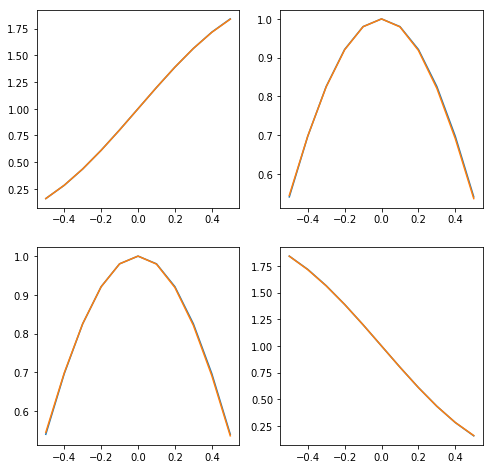

In [62]:
t = np.linspace(-0.5, 0.5, 11)
t.shape = (1, 11)
found_solution = predicted(t, L_model_forward(t, parameters, activation)[0]) 
t.shape = (11, )
analytic_solution = analytic_soln(t)
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(t, analytic_solution[0], t, found_solution[0])
plt.subplot(222)
plt.plot(t, analytic_solution[1], t, found_solution[1])
plt.subplot(223)
plt.plot(t, analytic_solution[2], t, found_solution[2])
plt.subplot(224)
plt.plot(t, analytic_solution[3], t, found_solution[3])
#plt.savefig('System of differential eqn soln.png')

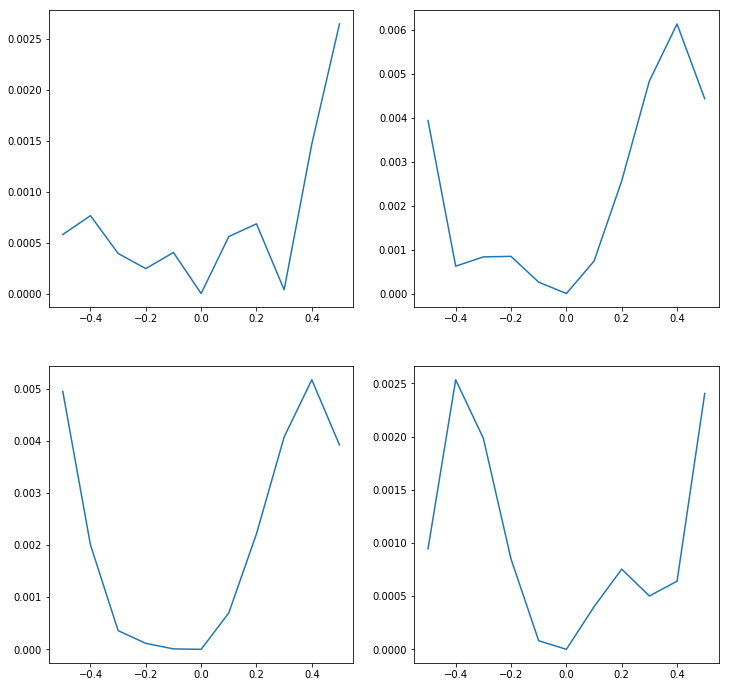

In [63]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(t, abs(analytic_solution[0] - found_solution[0]))
plt.subplot(222)
plt.plot(t, abs(analytic_solution[1] - found_solution[1]))
plt.subplot(223)
plt.plot(t, abs(analytic_solution[2] - found_solution[2]))
plt.subplot(224)
plt.plot(t, abs(analytic_solution[3] - found_solution[3]))
plt.savefig('Error_perc' + activation + '.png')

In [64]:
errors[activation] = np.sum(abs(analytic_solution - found_solution)*100/(analytic_solution))

In [65]:
errors

{'cos': 10.782195109495147,
 'relu': 1.4194564944849306,
 'sigmoid': 10.530801710085951,
 'softplus': 18.439358623334417,
 'tanh': 3.9797257874497824}

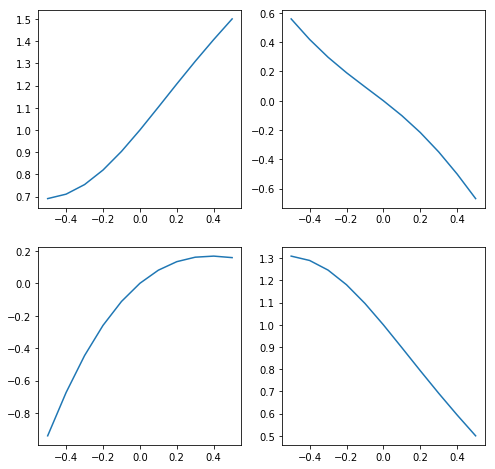

In [37]:
t = np.linspace(-0.5, 0.5, 11)
t.shape = (1, 11)
found_solution = predicted(t, L_model_forward(t, parameters, activation)[0]) 
t.shape = (11, )
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(t, found_solution[0])
plt.subplot(222)
plt.plot(t, found_solution[1])
plt.subplot(223)
plt.plot(t, found_solution[2])
plt.subplot(224)
plt.plot(t, found_solution[3])

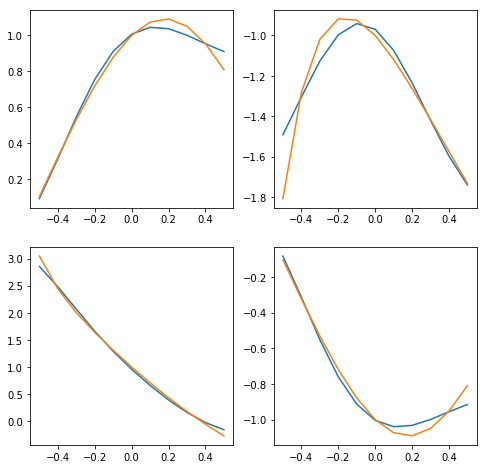

In [38]:
t = np.linspace(-0.5, 0.5, 11)
t.shape = (1, 11)
AL, _, dAL = L_model_forward(t, parameters, activation)
grad_found_solution = grad_predicted(t, AL, dAL) 
X = predicted(t, AL)
h1 = np.exp(t)
g1 = (1 + t**2)
g2 = (1 + t) ** 2
f1 = h1/g1
f2 = h1/g2
expected = np.array([X[2] + X[1] + f1, X[3] - X[0] - f2, -X[0] + X[3] + f2, -X[1] - X[2] - f1]).reshape(4, t.shape[1])
t.shape = (11, )
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(t, grad_found_solution[0], t, expected[0])
plt.subplot(222)
plt.plot(t, grad_found_solution[1], t, expected[1])
plt.subplot(223)
plt.plot(t, grad_found_solution[2], t, expected[2])
plt.subplot(224)
plt.plot(t, grad_found_solution[3], t, expected[3])